In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!nvidia-smi


Mon Feb 16 08:11:08 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
# Install the missing Indonesian NLP library
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 17.6 MB/s eta 0:00:00


In [36]:
import os
import re
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score


# Transformers specific imports
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Indonesian specific tool (optional but helpful for later)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

print("✅ All libraries imported and ready!")
print(f"Using Device: {'GPU (Tesla T4)' if torch.cuda.is_available() else 'CPU'}")

✅ All libraries imported and ready!
Using Device: GPU (Tesla T4)


In [3]:
from google.colab import files
files.upload()  # Choose your kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'\r\n{\r\n  "username": "akyhas14",\r\n  "key": "KGAT_9265a98ec71ad07553b13cdc6dd2a919"\r\n}\r\n'}

In [4]:
# 1. Move the token to the hidden folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# 2. Download the Indonesian Twitter Emotion dataset
!kaggle datasets download -d dennisherdi/indonesian-twitter-emotion

Dataset URL: https://www.kaggle.com/datasets/dennisherdi/indonesian-twitter-emotion
License(s): unknown
  0% 0.00/359k [00:00<?, ?B/s]
100% 359k/359k [00:00<00:00, 978MB/s]


In [6]:
# 3. Unzip the file
!unzip -q indonesian-twitter-emotion.zip

In [7]:
# 4. Check the file name
import os
print(f"Files in directory: {os.listdir()}")

Files in directory: ['.config', 'Twitter_Emotion_Dataset.csv', 'indonesian-twitter-emotion.zip', 'kamus_singkatan.csv', 'sample_data']


In [8]:
import pandas as pd

# Load dataset
df = pd.read_csv('Twitter_Emotion_Dataset.csv')

# Check the first few rows and class distribution
print(df.head())
print("\nEmotion Distribution:")
print(df['label'].value_counts())

   label                                              tweet
0  anger  Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...
1  anger  Sesama cewe lho (kayaknya), harusnya bisa lebi...
2  happy  Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3  anger  Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...
4  happy  Sharing pengalaman aja, kemarin jam 18.00 bata...

Emotion Distribution:
label
anger      1101
happy      1017
sadness     997
fear        649
love        637
Name: count, dtype: int64


In [10]:
# Normalization
# Define Indonesian slang dictionary
norm_dict = {
    "yg": "yang", "gak": "tidak", "gk": "tidak", "tdk": "tidak",
    "bgt": "banget", "sdh": "sudah", "udh": "sudah", "udah": "sudah",
    "gw": "saya", "gue": "saya", "lo": "kamu", "lu": "kamu",
    "pake": "pakai", "aja": "saja", "aj": "saja", "kalo": "kalau"
}

import re

def clean_tweet(text):
    text = text.lower()
    # Remove URLS, User Mentions, and Hashtag symbols
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    # Basic Slang Normalization
    words = text.split()
    words = [norm_dict[w] if w in norm_dict else w for w in words]
    return " ".join(words)

# Apply cleaning
df['cleaned_tweet'] = df['tweet'].apply(clean_tweet)

In [13]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
le = LabelEncoder()

# Fit and transform the labels
df['label_id'] = le.fit_transform(df['label'])

# Create a mapping for later reference
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Label Mapping: {mapping}")
# Output: {'anger': 0, 'fear': 1, 'happy': 2, 'love': 3, 'sadness': 4}

Label Mapping: {'anger': np.int64(0), 'fear': np.int64(1), 'happy': np.int64(2), 'love': np.int64(3), 'sadness': np.int64(4)}


In [19]:
# Stratified Train-Test Split
# We use the cleaned_tweet we created in the previous step
X = df['cleaned_tweet'].values
y = df['label_id'].values

# Split into Train (80%) and a temporary Test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split the 20% into Validation (10%) and final Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 3520 samples
Validation set: 440 samples
Test set: 441 samples


In [21]:
#Initialize the IndoBERT Tokenizer
model_name = "indobenchmark/indobert-base-p2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Helper function to tokenize the data
def tokenize_function(text_list):
    return tokenizer(
        list(text_list),
        padding='max_length',
        truncation=True,
        max_length=128, # Standard for tweets
        return_tensors="pt"
    )

# Tokenize all sets
train_encodings = tokenize_function(X_train)
val_encodings = tokenize_function(X_val)
test_encodings = tokenize_function(X_test)

print("✅ Tokenization complete!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

✅ Tokenization complete!


In [22]:
# creating a pytorch dataset
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Wrap our data
train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset = EmotionDataset(val_encodings, y_val)
test_dataset = EmotionDataset(test_encodings, y_test)

print("✅ Datasets ready for the GPU!")

✅ Datasets ready for the GPU!


In [23]:
# Step 9: Initialize IndoBERT Model
# Load the pre-trained model with a sequence classification head
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5
)

# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"IndoBERT is loaded on: {device}")

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: indobenchmark/indobert-base-p2
Key               | Status  | 
------------------+---------+-
classifier.weight | MISSING | 
classifier.bias   | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


IndoBERT is loaded on: cuda


In [25]:
#evalaution metrics
def compute_metrics(eval_pred):
    # eval_pred contains the model's raw guesses (logits) and the true labels
    logits, labels = eval_pred

    # Take the highest probability as the predicted class
    predictions = np.argmax(logits, axis=-1)

    # Calculate accuracy
    acc = accuracy_score(labels, predictions)

    # Calculate weighted F1-score (accounts for class imbalance)
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': acc,
        'f1': f1
    }

print("✅ Evaluation metrics defined successfully.")

✅ Evaluation metrics defined successfully.


In [28]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",           # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,
    report_to="none"
)

print("✅ Training configuration (Step 11) is now fixed and ready.")

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


✅ Training configuration (Step 11) is now fixed and ready.


In [32]:
# Training phase
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Start the training
print("🚀 Training started... This will take a few minutes on the T4 GPU.")
trainer.train()

🚀 Training started... This will take a few minutes on the T4 GPU.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.292477,0.942201,0.697727,0.695192
2,0.547452,0.845510,0.725000,0.718582
3,0.394269,0.886968,0.729545,0.730561
4,0.116006,1.402879,0.727273,0.725637
5,0.009834,1.434077,0.752273,0.752323


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=1100, training_loss=0.3221939856626771, metrics={'train_runtime': 213.6573, 'train_samples_per_second': 82.375, 'train_steps_per_second': 5.148, 'total_flos': 1157719826841600.0, 'train_loss': 0.3221939856626771, 'epoch': 5.0})

In [34]:
# testing on test Dataset:
# Evaluate on the test set
test_results = trainer.evaluate(test_dataset)

print("--- FINAL TEST SET RESULTS ---")
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"Test F1-Score: {test_results['eval_f1']:.4f}")

--- FINAL TEST SET RESULTS ---
Test Accuracy: 0.7596
Test F1-Score: 0.7612


--- DETAILED PERFORMANCE REPORT ---
              precision    recall  f1-score   support

       anger       0.76      0.82      0.79       110
        fear       0.79      0.80      0.79        65
       happy       0.83      0.71      0.76       102
        love       0.90      0.83      0.86        64
     sadness       0.62      0.68      0.65       100

    accuracy                           0.76       441
   macro avg       0.78      0.77      0.77       441
weighted avg       0.77      0.76      0.76       441



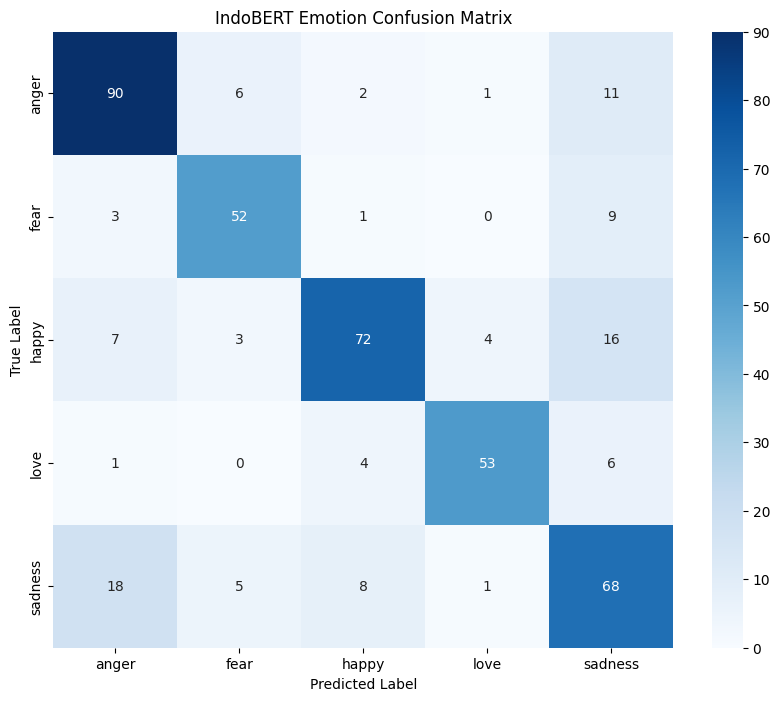

In [38]:
from sklearn.metrics import classification_report

# 1. Get predictions (if not already stored)
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=-1)

# 2. Print the text-based summary for verification
print("--- DETAILED PERFORMANCE REPORT ---")
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

# 3. Visual plot (for your reference)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('IndoBERT Emotion Confusion Matrix')
plt.show()

In [42]:
# predicting using  manual samples:
def predict_emotion(text):
    # 1. Clean and Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding='max_length')
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 2. Get Prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # 3. Process Result
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_idx = torch.argmax(probs, dim=-1).item()
    emotion = le.classes_[pred_idx]
    confidence = probs[0][pred_idx].item()

    return emotion, confidence

# Updated loop to handle the list of tweets
my_tweets = [
    "aku sangat bahagia hari ini",
    "aku merasa kecewa dan sedih",
    "aku sangat marah dengan keadaan ini",
    "hari ini aku takut sendirian"
]

print("--- MANUAL TEST RESULTS ---")
for tweet in my_tweets:
    emotion, score = predict_emotion(tweet)
    print(f"Tweet: {tweet}")
    print(f"Predicted Emotion: {emotion} ({score*100:.2f}%)")
    print("-" * 30)

--- MANUAL TEST RESULTS ---
Tweet: aku sangat bahagia hari ini
Predicted Emotion: happy (99.93%)
------------------------------
Tweet: aku merasa kecewa dan sedih
Predicted Emotion: sadness (99.96%)
------------------------------
Tweet: aku sangat marah dengan keadaan ini
Predicted Emotion: sadness (99.16%)
------------------------------
Tweet: hari ini aku takut sendirian
Predicted Emotion: fear (99.94%)
------------------------------


In [47]:
import os
import shutil
import joblib

# 1. Create a local directory for the model
save_directory = "./indobert_emotion_model"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# 2. Save the model and tokenizer using the trainer
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

# 3. Save the LabelEncoder (CRITICAL for local VS Code use)
joblib.dump(le, os.path.join(save_directory, "label_encoder.joblib"))

# 4. Zip the folder so you can download it as one file
shutil.make_archive("indobert_emotion_model", 'zip', save_directory)

print("Model, Tokenizer, and Label Encoder saved and zipped!")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model, Tokenizer, and Label Encoder saved and zipped!


In [44]:
from google.colab import drive
drive.mount('/content/drive')

# This path IS valid because it points to Google's cloud storage
save_path_drive = "/content/drive/MyDrive/my_local_project_folder"
trainer.save_model(save_path_drive)

Mounted at /content/drive


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
# 1. Save the tokenizer (the part that turns words into numbers)
tokenizer.save_pretrained(save_path_drive)

# 2. Save the Label Encoder (the part that knows 0=anger, 1=fear, etc.)
import joblib
import os
joblib.dump(le, os.path.join(save_path_drive, "label_encoder.joblib"))

print(f" All components (Model, Tokenizer, Label Encoder) are now in {save_path_drive}")

 All components (Model, Tokenizer, Label Encoder) are now in /content/drive/MyDrive/my_local_project_folder


In [48]:
import shutil
import os

# 1. Save EVERYTHING to Colab's local temporary disk first (not Drive)
local_save = "./temp_model_folder"
os.makedirs(local_save, exist_ok=True)
model.save_pretrained(local_save)
tokenizer.save_pretrained(local_save)
joblib.dump(le, os.path.join(local_save, "label_encoder.joblib"))

# 2. Zip it into ONE file
zip_name = "goat_model_final"
shutil.make_archive(zip_name, 'zip', local_save)

# 3. Move that ONE zip file to your Drive
drive_path = "/content/drive/MyDrive/goat_model_final.zip"
shutil.move(f"{zip_name}.zip", drive_path)

print(f"✅ Success! Check your Drive for '{zip_name}.zip'. It's one single GOAT file.")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Success! Check your Drive for 'goat_model_final.zip'. It's one single GOAT file.


In [57]:
import json
import os

# Use the path you just copied from the sidebar
notebook_path = "/content/drive/MyDrive/Colab_Notebooks/TweetClassification.ipynb"

if os.path.exists(notebook_path):
    with open(notebook_path, "r", encoding="utf-8") as f:
        nb = json.load(f)

    # The 'robber' metadata check
    if "metadata" in nb and "widgets" in nb["metadata"]:
        del nb["metadata"]["widgets"]
        print("✅ Success! The 'metadata.widgets' key has been removed.")
    else:
        print("ℹ️ No 'widgets' key found. Your notebook might be clean already.")

    # Save the cleaned version
    with open(notebook_path, "w", encoding="utf-8") as f:
        json.dump(nb, f, indent=2)
else:
    print(f"❌ Error: Could not find file at: {notebook_path}")
    print("Check if your Drive is mounted and the filename is spelled correctly.")

✅ Success! The 'metadata.widgets' key has been removed.


In [58]:
import nbformat

notebook_path = "/content/drive/MyDrive/Colab_Notebooks/TweetClassification.ipynb"

# Read the notebook
with open(notebook_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Force the widget metadata to have a valid 'state' key
if "widgets" not in nb.metadata:
    nb.metadata["widgets"] = {"application/vnd.jupyter.widget-state+json": {"state": {}}}
else:
    # If it exists but is broken, reset it to a clean empty state
    nb.metadata["widgets"] = {"application/vnd.jupyter.widget-state+json": {"state": {}}}

# Save the fixed notebook
with open("TweetClassification_Fixed.ipynb", "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print("✅ Success! The 'state' key has been forced into metadata.")

✅ Success! The 'state' key has been forced into metadata.
